In [17]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
fs_df = pd.read_pickle('../data/fs_df.pkl')
cs5_df = pd.read_pickle('../data/cs5_df.pkl')
cs6_df = pd.read_pickle('../data/cs6_df.pkl')
fs_df = fs_df.drop(columns=['REQMEM','REQTIME'])

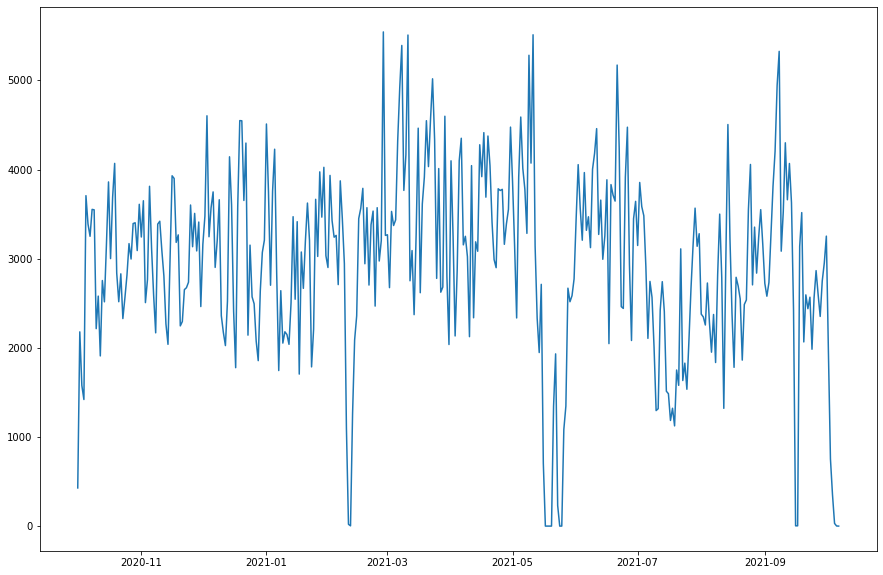

In [10]:
begin_load_df = fs_df[fs_df['PARTITION'] == 'production'][['BEGIN']].rename(columns={'BEGIN':'TIME'})
begin_load_df['process'] = 1
end_load_df = fs_df[fs_df['PARTITION'] == 'production'][['END']].rename(columns={'END':'TIME'})
end_load_df['process'] = -1
load_df = begin_load_df.append(end_load_df)

resample_interval = "D"
fs_ts = pd.Series(list(load_df['process']), index=list(load_df['TIME']))
fs_resample = fs_ts.resample(resample_interval).sum().to_frame().cumsum()

plt.figure(figsize=(15, 10))
plt.plot(fs_resample.index, fs_resample[0])

In [11]:
cs5_ts = pd.Series(list(cs5_df['RETURNCODE']), index=list(cs5_df['TIME']))
cs6_ts = pd.Series(list(cs6_df['RETURNCODE']), index=list(cs6_df['TIME']))
cs5_resample = cs5_ts.resample(resample_interval).sum()
cs6_resample = cs6_ts.resample(resample_interval).sum()
cs_resample = cs5_resample + cs6_resample

In [29]:
resample_df = fs_resample.join(cs_resample.to_frame(), lsuffix='_fs', rsuffix='_cs').dropna()

In [18]:
y=resample_df['0_cs']
X=resample_df['0_fs']
model = sm.OLS(y, X).fit()

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   0_cs   R-squared (uncentered):                   0.251
Model:                            OLS   Adj. R-squared (uncentered):              0.249
Method:                 Least Squares   F-statistic:                              119.4
Date:                Tue, 26 Oct 2021   Prob (F-statistic):                    3.67e-24
Time:                        15:02:58   Log-Likelihood:                         -1516.0
No. Observations:                 357   AIC:                                      3034.
Df Residuals:                     356   BIC:                                      3038.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0_fs           0.0031      0.000     10.927      0.000       0.003       0.004
==============================================================================
Omnibus:                      312.090   Durbin-Watson:                   1.231
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5864.779
Skew:                           3.722   Prob(JB):                         0.00
Kurtosis:                      21.408   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

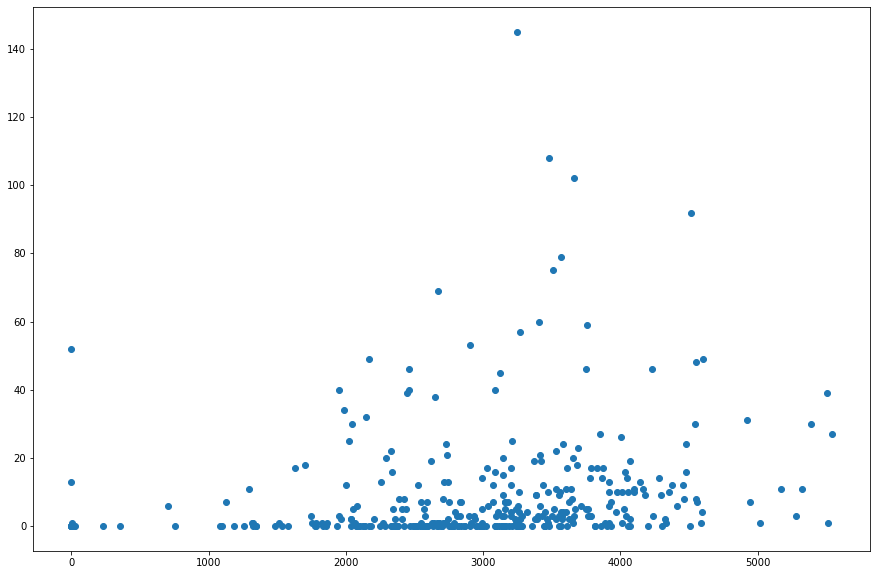

In [20]:
plt.figure(figsize=(15, 10))
plt.scatter(resample_df['0_fs'], resample_df['0_cs'])

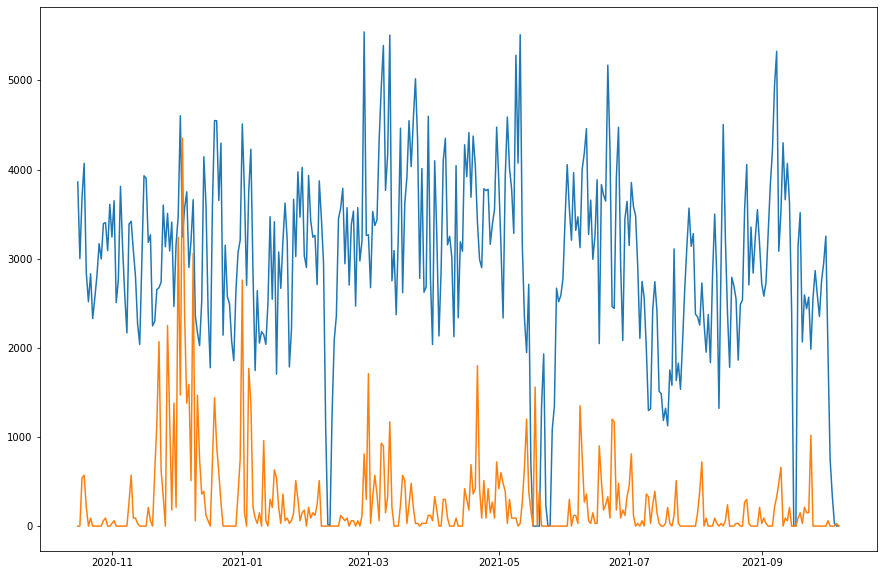

In [34]:
resample_df['0_cs_scaled'] = resample_df['0_cs'] * 30
plt.figure(figsize=(15, 10))
plt.plot(resample_df.index, resample_df['0_fs'])
plt.plot(resample_df.index, resample_df['0_cs_scaled'])